In [69]:
#Importing the Libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [70]:
#Loading the dataset
data = pd.read_csv("/content/marketing_campaign.csv", sep = "\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [71]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [72]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [75]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"] , format ="%d-%m-%Y")
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [79]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1-i
    delta = delta.days
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [81]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [82]:
#Feature Engineering
#Age of customer today
data["Age"] = 2024-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [83]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,353.521209,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,202.434667,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,180.000000,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,355.500000,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,529.000000,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,699.000000,131.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

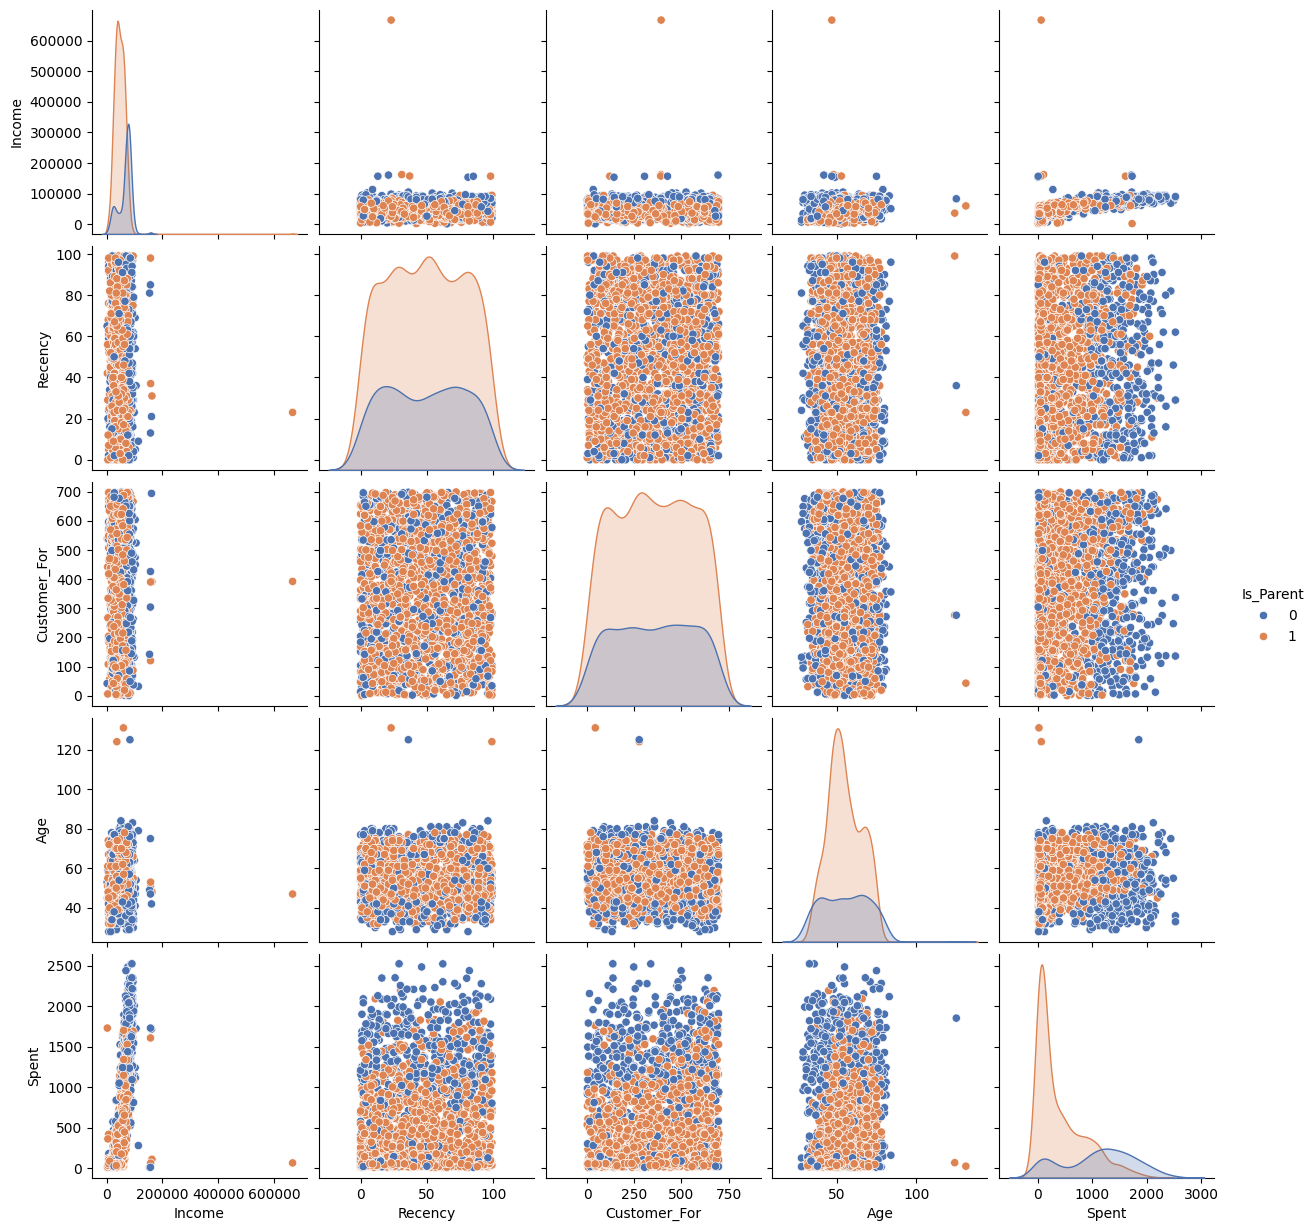

In [84]:
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent")

plt.show()

In [85]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


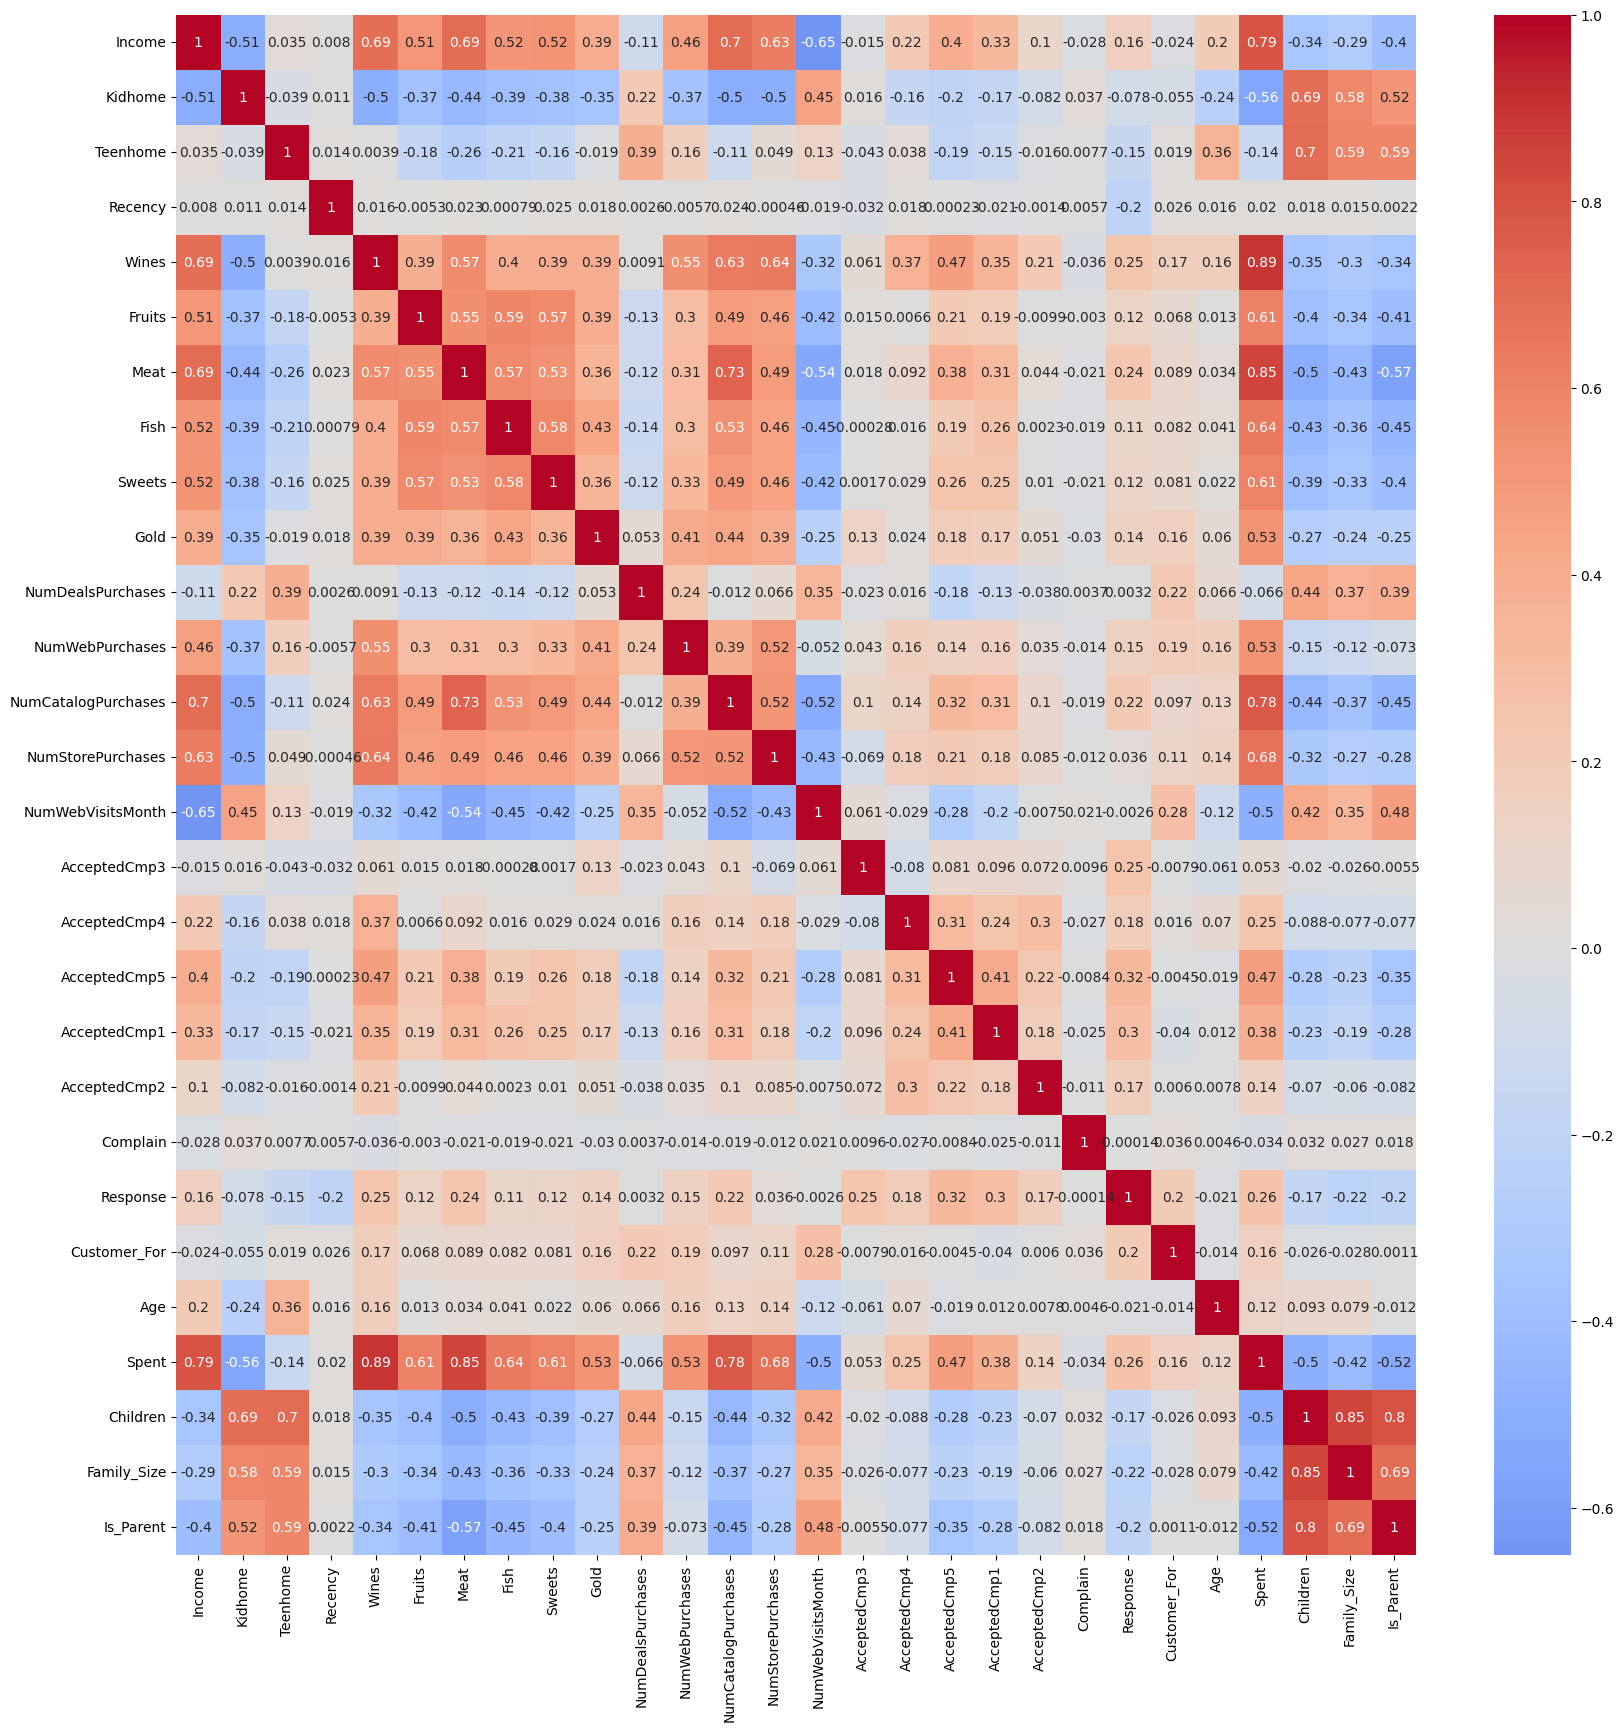

In [86]:
#correlation matrix
data_num = data.drop(["Education", "Living_With"],axis = 1)
corrmat= data_num.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True,center=0, cmap = "coolwarm")
plt.show()

In [87]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [88]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [89]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [90]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


In [91]:
#Reduicng Dimu using PCA
pca = PCA()
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds))

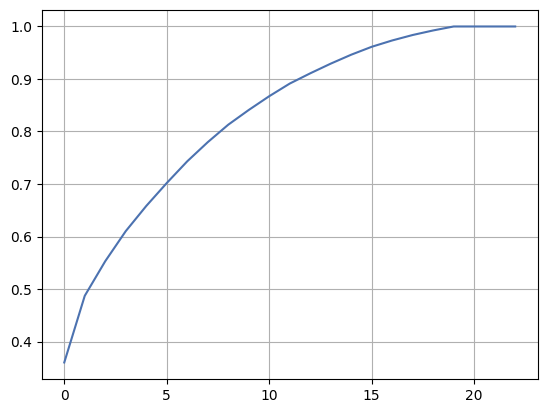

In [92]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.grid()
plt.show()

In [93]:
pd.DataFrame({
    "PC Number" : range(1,scaled_ds.shape[1]+1),
    "Var_explained" : np.cumsum(pca.explained_variance_ratio_)*100
})

,PC Number,Var_explained
0,1,36.011321
1,2,48.711165
2,3,55.304060
3,4,61.025046
4,5,65.815522
5,6,70.186034
6,7,74.321393
7,8,77.965241
8,9,81.292328
9,10,84.096401


In [94]:
#Initiating PCA to reduce dimentions aka features to 3 for Visualizing
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["PC1","PC2", "PC3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,2212.0,6.424437e-18,2.878602,-5.978123,-2.539470,-0.781595,2.386380,7.452915
PC2,2212.0,-5.781993e-17,1.709469,-4.194757,-1.323932,-0.173716,1.234923,6.168185
PC3,2212.0,1.485651e-17,1.231685,-3.625184,-0.853556,-0.051292,0.863841,6.746845


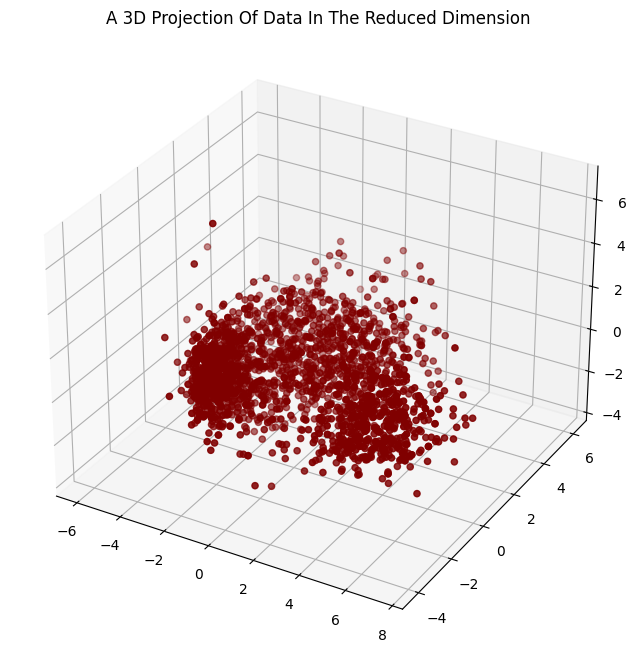

In [98]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["PC1"]
y =PCA_ds["PC2"]
z =PCA_ds["PC3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


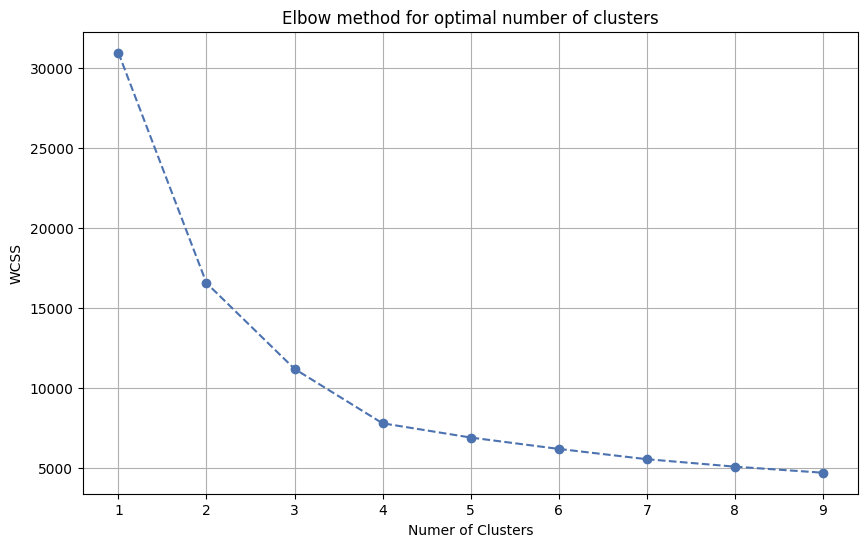

In [99]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
wcss = []
max_clusters = 10
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters=i, init = "k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(PCA_ds)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1,max_clusters), wcss, marker = "o", linestyle = "--")
plt.title("Elbow method for optimal number of clusters")
plt.xlabel("Numer of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [100]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

In [101]:
def compute_centroids(X, labels, n_clusters):
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(n_clusters)])
    return centroids
def compute_wcss(X, labels, n_clusters):
    centroids = compute_centroids(X, labels, n_clusters)
    wcss = 0
    for i in range(len(centroids)):
        wcss += np.sum((X[labels == i] - centroids[i])**2)
    return wcss


In [102]:
X = PCA_ds.values
compute_wcss(X, yhat_AC, 4)

7918.224135132215

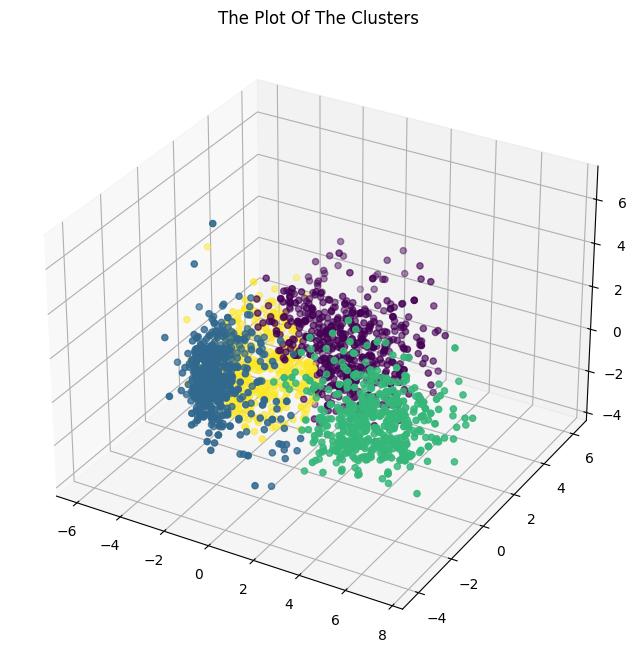

In [103]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, c=PCA_ds["Clusters"], marker='o')
ax.set_title("The Plot Of The Clusters")
plt.show()

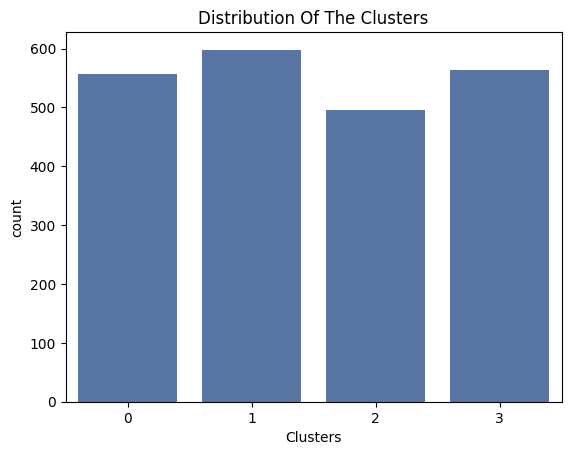

In [104]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

In [105]:
# PCA with 8 components
pca = PCA(n_components=8)
pca.fit(scaled_ds)
PCA_ds8 = pd.DataFrame(pca.transform(scaled_ds), columns=(["PC" + str(i) for i in range(1,9)]))


Elbow Method to determine the number of clusters to be formed:


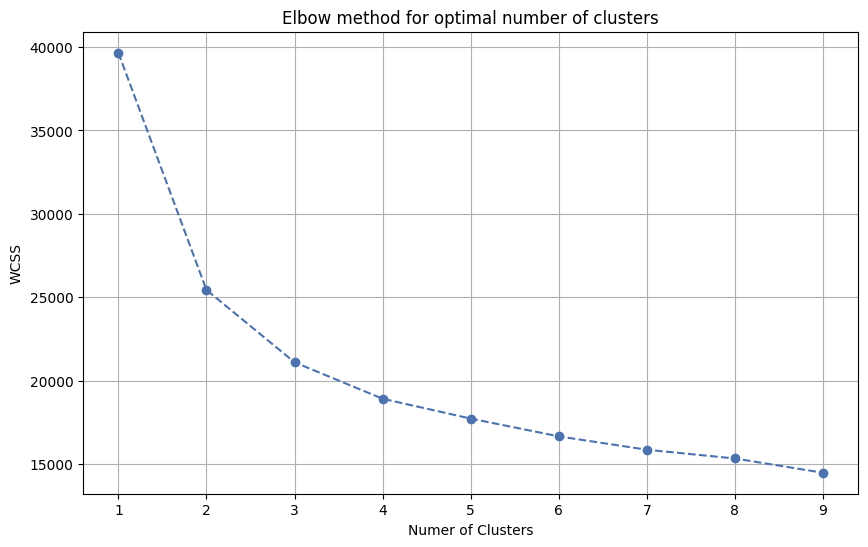

In [106]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
wcss = []
max_clusters = 10
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters=i, init = "k-means++", max_iter=300, n_init=10, random_state=0)
    kmeans.fit(PCA_ds8)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10,6))
plt.plot(range(1,max_clusters), wcss, marker = "o", linestyle = "--")
plt.title("Elbow method for optimal number of clusters")
plt.xlabel("Numer of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

In [107]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds8)
PCA_ds8["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters_PCA_8"]= yhat_AC

In [108]:
X = PCA_ds8.values
compute_wcss(X, yhat_AC, 4)

19757.737072636162

In [109]:
kmeans = KMeans(n_clusters=4, init = "k-means++", max_iter=300, n_init=10, random_state=0)
kmeans.fit(PCA_ds8)
yhat_Kmeans = kmeans.predict(PCA_ds8)

In [110]:
X = PCA_ds8.values
compute_wcss(X, yhat_Kmeans, 4)

19290.006110966286

In [111]:
data = data.drop(["Clusters", "Clusters_PCA_8"], axis=1)

In [112]:
data["Clusters"]= yhat_Kmeans

Cluster Profile

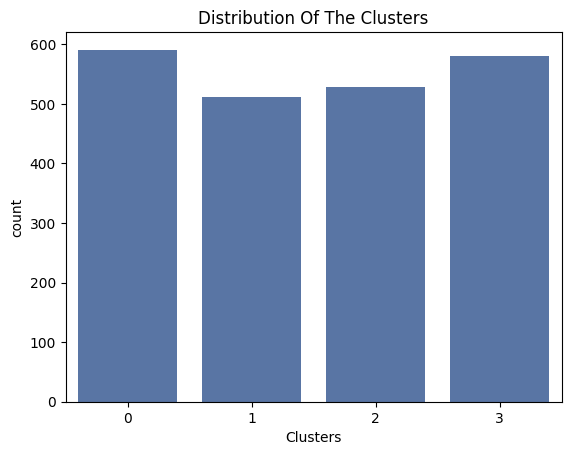

In [113]:
#Plotting countplot of clusters
pl = sns.countplot(x=data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

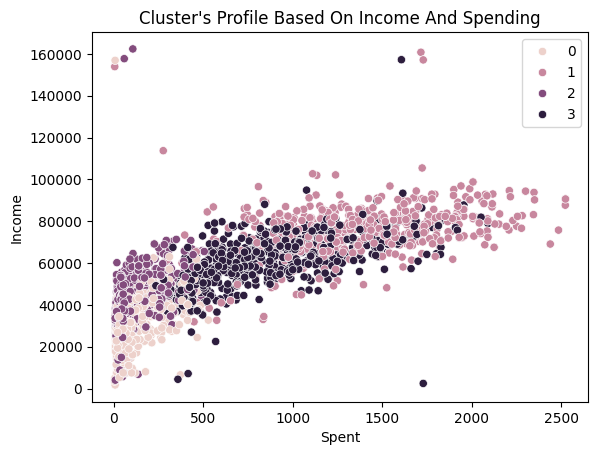

In [114]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"])
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

In [115]:
data.groupby("Clusters").median()[["Spent", "Income"]]

,Spent,Income
Clusters,,
0,64.0,29999.0
1,1355.5,76580.0
2,84.5,42586.0
3,819.0,61331.0


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 74.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 69.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 78.7% of the points cannot be plac

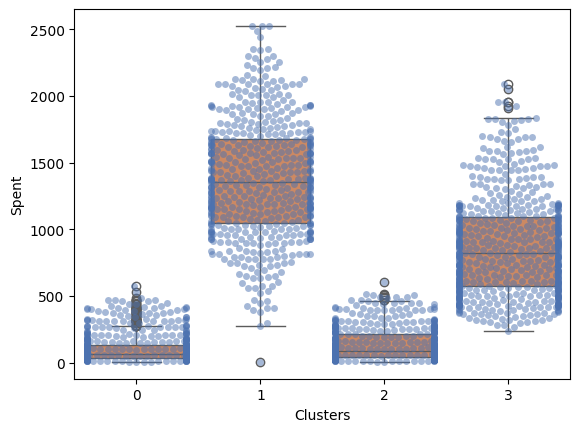

In [116]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], alpha=0.5 )
pl=sns.boxplot(x=data["Clusters"], y=data["Spent"],)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 58.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 52.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 58.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 65.0% of the points cannot be plac

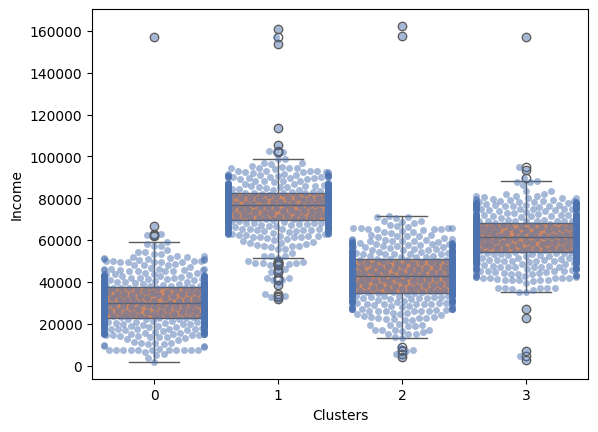

In [117]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Income"], alpha=0.5 )
pl=sns.boxplot(x=data["Clusters"], y=data["Income"])
plt.show()

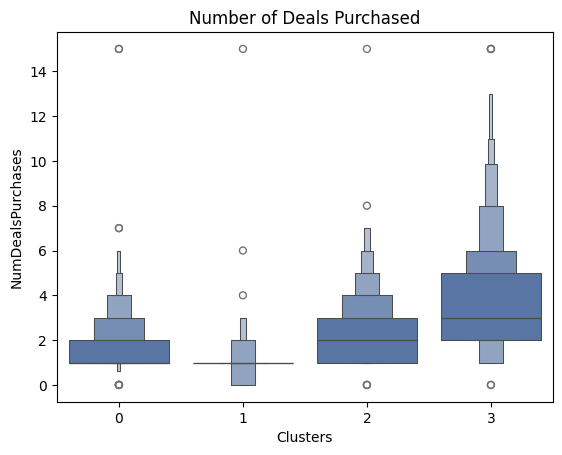

In [118]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"])
pl.set_title("Number of Deals Purchased")
plt.show()

In [119]:
Personal = ["Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

round(data.groupby("Clusters")[Personal].mean().T,2)


Clusters,0,1,2,3
Kidhome,0.76,0.01,0.76,0.21
Teenhome,0.02,0.04,1.01,0.96
Customer_For,346.81,348.23,290.23,423.26
Age,47.27,55.69,59.27,58.70
Children,0.78,0.04,1.77,1.17
Family_Size,2.41,1.63,3.47,2.83
Is_Parent,0.77,0.04,1.00,0.99
Education,0.69,0.57,0.62,0.55
Living_With,0.64,0.59,0.70,0.66


In [120]:
data.groupby("Clusters")[Personal].median().T

Clusters,0,1,2,3
Kidhome,1.0,0.0,1.0,0.0
Teenhome,0.0,0.0,1.0,1.0
Customer_For,341.0,347.5,265.0,454.0
Age,46.0,55.0,59.0,58.0
Children,1.0,0.0,2.0,1.0
Family_Size,2.0,2.0,3.0,3.0
Is_Parent,1.0,0.0,1.0,1.0
Education,0.0,0.0,1.0,0.0
Living_With,1.0,1.0,1.0,1.0
